### Basic Grammar Checker from GingerIt

In [1]:
from gingerit.gingerit import GingerIt

In [2]:
text = 'The smelt of fliwers bring back memories.'

parser = GingerIt()
text_ = parser.parse(text)
text_['result']
parser.parse('I is glad to has good frends like you')

{'text': 'I is glad to has good frends like you',
 'result': 'I am glad to have good friends like you',
 'corrections': [{'start': 22,
   'text': 'frends',
   'correct': 'friends',
   'definition': 'a person you know well and regard with affection and trust'},
  {'start': 13, 'text': 'has', 'correct': 'have', 'definition': None},
  {'start': 2, 'text': 'is', 'correct': 'am', 'definition': None}]}

### Formality Classifier (Work in Progress)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import time
nltk.download('stopwords')
nltk.download('wordnet')

# Reading in the csv as a dataframe
df = pd.read_csv('formal_informal_data.csv', encoding = "utf-8")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df.head()

,text,label
0,"When guys wear boxers, they look like little b...",1
1,not asking just tempting to see if he goes for...,1
2,most -14feb 25th dec and 15th june least-apri...,1
3,Is it too difficult to say GOOD BYE to somebod...,0
4,busting his balls and his friends balls.,1


In [5]:
df['text'] = df['text'].astype(str)

In [6]:
df['text']

0        When guys wear boxers, they look like little b...
1        not asking just tempting to see if he goes for...
2        most -14feb 25th dec and 15th june  least-apri...
3        Is it too difficult to say GOOD BYE to somebod...
4                 busting his balls and his friends balls.
                               ...                        
49995              Women donot think about gay men at all.
49996    Having bigger breasts might be cool for the bo...
49997                    Did you ask her why she did that?
49998    IF YOU THINK LIFE IS SO DIFFICULT RIGHT NOW, M...
49999    LOOKING FOR THE SAME THING THAT LED YOU TO THE...
Name: text, Length: 50000, dtype: object

In [7]:
# Basic Text Cleaning
stop_words = stopwords.words('english')

# Removing apostrophes so contractions are considered a single token
df['clean_text'] = df['text'].apply(lambda x: re.sub("'", '', x))

# Remove punctuation and stop words and lowercase the text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(re.sub(
    r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words))

In [8]:
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(w) for w in x.split()))

In [9]:
# Split the data into a training and test set for H2O
train, test = train_test_split(df, test_size=0.15, random_state = 123)

In [10]:
# Vectorize each tweet using Tf-Idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a Tf-Idf vectorizer that uses words as features if they occur at
# least 3 times in the corpus and include bigrams
vectorizer = TfidfVectorizer(ngram_range = (1, 2)) 

# Fit the vectorizer to the cleaned training data
vectorizer.fit(train['clean_text'])

# Vectorize the text for both the training and testing set
tfidf_train = vectorizer.transform(train['clean_text'])
tfidf_test  = vectorizer.transform(test['clean_text'])

In [11]:
# Train/use a Random Forest forest model for classification
from sklearn.ensemble import RandomForestClassifier

# Instantiate a model with 500 trees
rfc = RandomForestClassifier(n_estimators=1, random_state = 123)

# Fit to the training data
rfc = rfc.fit(tfidf_train, train['label'])

# Test the accuracy of the model on the testing data
test_set_acc = rfc.score(tfidf_test, test['label'])

print(f'Random Forest labeling accuracy: {str(round(test_set_acc*100,2))}')

Random Forest labeling accuracy: 37.99


Text(0.5, 1.0, 'Relative Importance of Features')

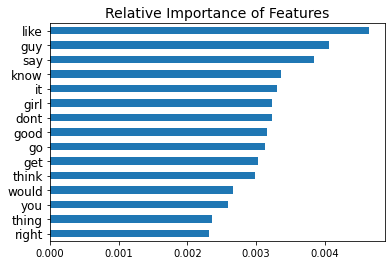

In [12]:
import matplotlib.pyplot as plt

# Convert vectors back to words to plot variable importance
ft_importances = pd.Series(rfc.feature_importances_, index=vectorizer.get_feature_names())
ft_importances.nlargest(15).sort_values().plot(kind='barh')
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.title("Relative Importance of Features",fontsize = 14)

## Sentence Level Probability

In [13]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from nltk.tokenize import sent_tokenize

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [14]:
def score(tokens_tensor):
    loss=model(tokens_tensor, labels=tokens_tensor)[0]
    return np.exp(loss.cpu().detach().numpy())

def GPT2_Sentence_Scorer(text):
    scores = []
    sentences = sent_tokenize(text)
    for sent in sentences:
        scores.append((score(tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")), sent))
    return scores

## Translation Models From HuggingFace

In [15]:
import numpy as np
import pandas as pd

import json
import requests

import torch
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast

In [16]:
API_TOKEN="api_oMMRDkimUuBHSmsDNophzfNCmbzfimIFRl"

models_dictionary = {'English to Spanish':"https://api-inference.huggingface.co/models/Helsinki-NLP/opus-mt-en-es",
                    'Spanish to English':"https://api-inference.huggingface.co/models/Helsinki-NLP/opus-mt-es-en",
                    'English to French':"https://api-inference.huggingface.co/models/Helsinki-NLP/opus-mt-en-fr",
                    'French to English':"https://api-inference.huggingface.co/models/Helsinki-NLP/opus-mt-fr-en",
                    'English to Chinese':"https://api-inference.huggingface.co/models/Helsinki-NLP/opus-mt-en-zh",
                    'Chinese to English':"https://api-inference.huggingface.co/models/Helsinki-NLP/opus-mt-zh-en"}

def query(payload, API_URL, headers):
    data = json.dumps(payload)
    response = requests.request("POST", API_URL, headers=headers, data=data)
    return json.loads(response.content.decode("utf-8"))

In [ ]:
import anvil.server

anvil.server.connect("HT2WEDUNUEDNPCY5IBJIRQUL-7OUNN73B65YOKSCK")

@anvil.server.callable
def grammar_checker(text):
    if parser.parse(text)['corrections']:
        return parser.parse(text)['result']
    else:
        return 'No corrections needed.'

@anvil.server.callable    
def formality_checker(text):
    text = re.sub("'", '', text)
    text = ' '.join(re.sub(
    r'[^a-zA-Z]',' ',w).lower() for w in text.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words)
    text = ' '.join(lemmatizer.lemmatize(w) for w in text.split())
    vector = vectorizer.transform([text])
    ynew = rfc.predict(vector)
    if ynew[0] == 1:
        return 'Informal'
    else:
        return 'Formal'
    
@anvil.server.callable
def translate(text, language):
    headers = {"Authorization": f"Bearer {API_TOKEN}"}
    API_URL = models_dictionary[language]
    result = query({"inputs":f'{text}',}, API_URL, headers)
    while 'error' in result:
        time.sleep(20)
        result = query({"inputs":f'{text}',}, API_URL, headers)
        print(result)
    return result[0]['translation_text']

@anvil.server.callable
def nat_sounding(text):
    list_of_scores = GPT2_Sentence_Scorer(text)
    good, okay, bad = [], [], []
    for sent in list_of_scores:
        if sent[0] > 100 and sent[0] < 200:
            okay.append(sent[1] + '\n')
        elif sent[0] >= 200:
            bad.append(sent[1] + '\n')
        else:
            good.append(sent[1] + '\n')
    if len(okay) == 0:
        okay.append('None')
    if len(bad) == 0:
        okay.append('None')
    print(list_of_scores)
    return (good,okay,bad)
    
anvil.server.wait_forever()

[(72.63806, 'As you can imagine, the subject line and tactics you should use change accordingly.'), (82.124664, 'So in this post, I’m going to tackle this long ignored topic:  I’m going to show you 27 business email templates and what makes them perform for any campaign you’re running.'), (191.3414, 'You’ll walk away from this knowing exactly what to write in your next message to get opens, clicks and conversions.'), (34.97196, 'Before you skim the templates below and start writing your own please go through the following checklist to ensure you pay attention to the following.'), (670.7987, 'fhewufih huewhif nhfweiu.')]
